# Modeling

In [354]:
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from copy import deepcopy
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder

# SMOTE
from imblearn.over_sampling import SMOTE

In [2]:
# integrating our preprocessing into a pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [3]:
# importing our corpues i.e., our processed tokens
corpus = pd.read_csv('data/spotify-reviews.csv')
corpus = corpus.rename(columns={'review':'tokens'})
spotify_df = pd.read_csv('data/preprocessed-reviews.csv')
spotify_reviews = pd.concat([spotify_df,corpus],axis=1)

In [4]:
data = spotify_reviews[spotify_reviews.sentiment.isin(['pos','neg'])]
data.head()

,review,rating,total_thumbs_up,replied,comp_score,pos_score,neg_score,sentiment,tokens
0,"great music service, the audio is high quality...",5,2,0,0.9211,0.436,0.000,pos,great music service audio high quality app eas...
1,please ignore previous negative rating. this a...,5,1,0,0.6249,0.404,0.243,pos,please ignore previous negative rating app sup...
2,"this pop-up ""get the best spotify experience o...",4,0,0,0.5859,0.258,0.107,pos,get best spotify experience android annoy plea...
3,really buggy and terrible to use as of recently,1,1,0,-0.5209,0.000,0.296,neg,really buggy terrible use recently
4,dear spotify why do i get songs that i didn't ...,1,1,0,0.7149,0.260,0.000,pos,dear spotify get song put playlist shuffle play


In [5]:
# instantiating our label encoder so that we can label our classes
label_enc = LabelEncoder()

In [6]:
X = data.tokens
y = data.sentiment
y = label_enc.fit_transform(y)

In [7]:
# looking at our class distribution 
data.sentiment.value_counts(normalize=True)

pos    0.695899
neg    0.304101
Name: sentiment, dtype: float64

In [8]:
# for more detailed labels later on 
class_labels = ['Negative','Positive']

In [9]:
# splitting our data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [10]:
# creating a pipeline for our vectorizer 
pre_process_steps = [('tfdif', TfidfVectorizer())]
preprocess_pipeline = Pipeline(pre_process_steps)
preprocess_pipeline

Pipeline(steps=[('tfdif', TfidfVectorizer())])

## Creating a Baseline DummyClassifier Model

In [11]:
# transforming our training and test data 
#X_train_processed = preprocess_pipeline.fit_transform(X_train)
#X_test_processed = preprocess_pipeline.transform(X_test)

To evaluate our future models, we'll use `DummyClasifier` from sklearn ~ 

In [12]:
from sklearn.dummy import DummyClassifier

In [13]:
dummy_pipe = deepcopy(preprocess_pipeline)
dummy_pipe.steps.append(('dummy_clf',DummyClassifier(random_state=42)))
dummy_pipe

Pipeline(steps=[('tfdif', TfidfVectorizer()),
                ('dummy_clf', DummyClassifier(random_state=42))])

In [14]:
# fitting our pipeline on the training data 
dummy_pipe.fit(X_train,y_train)

Pipeline(steps=[('tfdif', TfidfVectorizer()),
                ('dummy_clf', DummyClassifier(random_state=42))])

In [15]:
#extracting our predictions 
preds = dummy_pipe.predict(X_test)

### Confusion-Matrix Display

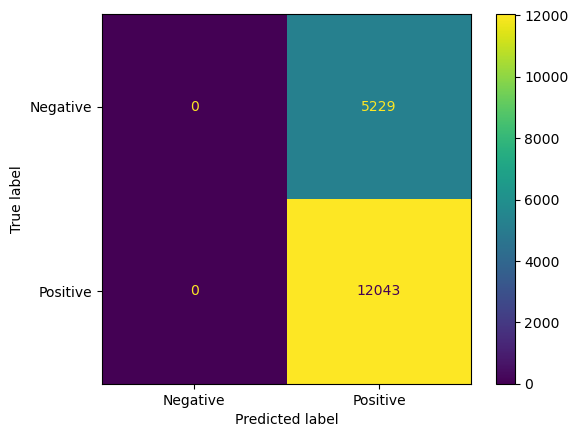

In [16]:
# creating a confusion matrix for our baseline dummy model 
ConfusionMatrixDisplay.from_predictions(y_test,preds,display_labels=['Negative','Positive'])

In [17]:
dummy_pipe.score(X_test,y_test)

0.6972556739231126

### Precision-Recall AUC (PR-AUC)

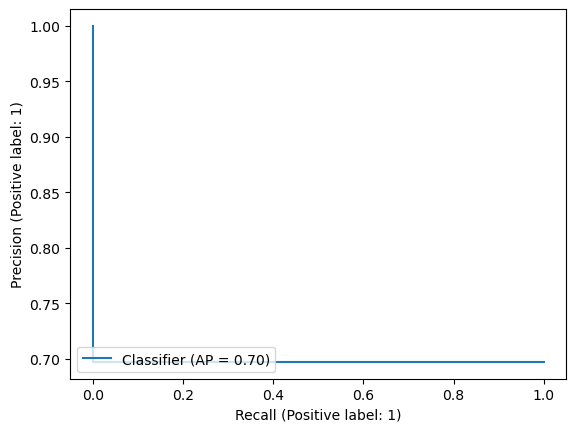

In [18]:
# plotting the precision-recall curve 
PrecisionRecallDisplay.from_predictions(y_test, preds)

### ROC-AUC Curve

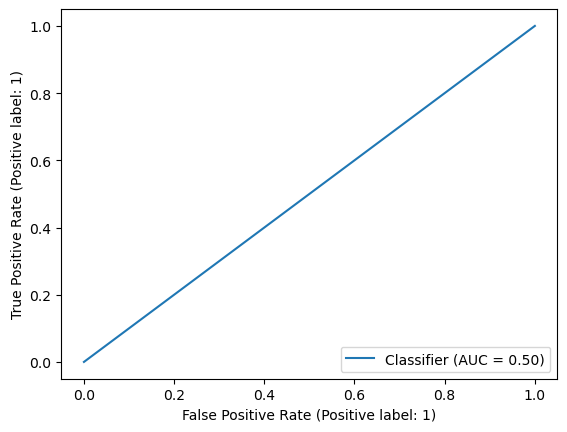

In [19]:
RocCurveDisplay.from_predictions(y_test, preds)

### Classification Report

In [20]:
print(classification_report(y_test,preds,target_names=class_labels,zero_division=1))

              precision    recall  f1-score   support

    Negative       1.00      0.00      0.00      5229
    Positive       0.70      1.00      0.82     12043

    accuracy                           0.70     17272
   macro avg       0.85      0.50      0.41     17272
weighted avg       0.79      0.70      0.57     17272



Our dummy model has a baseline accuracy of 70%, which is okay. 

## RandomForestClassifier

For our first model, we'll use `RandomForestClassifier`!

In [21]:
#imports
from sklearn.ensemble import RandomForestClassifier

In [22]:
rf_pipe = deepcopy(preprocess_pipeline)
rf_pipe.steps.append(('rf_clf',RandomForestClassifier(random_state=42)))
rf_pipe

Pipeline(steps=[('tfdif', TfidfVectorizer()),
                ('rf_clf', RandomForestClassifier(random_state=42))])

In [25]:
rf_pipe.fit(X_train,y_train)

Pipeline(steps=[('tfdif', TfidfVectorizer()),
                ('rf_clf', RandomForestClassifier(random_state=42))])

In [26]:
# extracting our predictions 
preds2 = rf_pipe.predict(X_test)

### Confusion Matrix Display

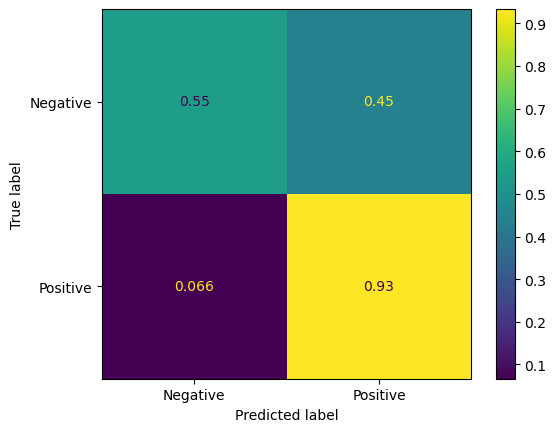

In [27]:
ConfusionMatrixDisplay.from_predictions(y_test, preds2,normalize='true',display_labels=class_labels)

In [28]:
rf_pipe.score(X_test,y_test)

0.818723946271422

### Classification Report 

In [29]:
print(classification_report(y_test,preds2))

              precision    recall  f1-score   support

           0       0.78      0.55      0.65      5229
           1       0.83      0.93      0.88     12043

    accuracy                           0.82     17272
   macro avg       0.81      0.74      0.76     17272
weighted avg       0.81      0.82      0.81     17272



### ROC 

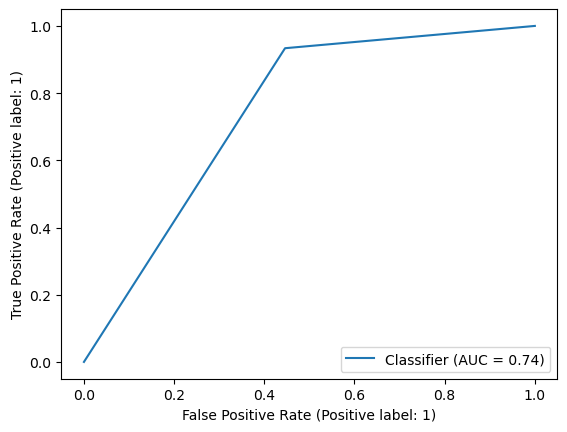

In [30]:
RocCurveDisplay.from_predictions(y_test,preds2)

### Precision-Recall Curve

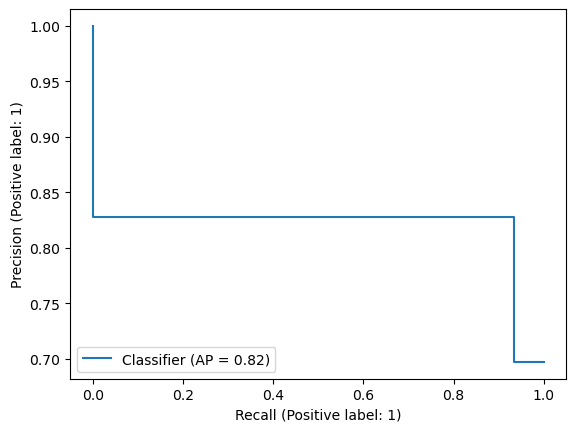

In [31]:
PrecisionRecallDisplay.from_predictions(y_test,preds2)

## Model Tuning

In [288]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [290]:
rf_rcv_params = {'tfdif__min_df':[.01,.03,.05],
                    'tfdif__max_df':[.85,.90,.95],
                    'rf_clf__n_estimators':[50,100,150],
                    'rf_clf__min_samples_split':[5,10,100,150],
                    'rf_clf__min_samples_split':[5,10,100,150]}

In [291]:
rf_random_cv = RandomizedSearchCV(estimator=rf_pipe,
                               param_distributions=rf_rcv_params,
                               cv=5)
rf_random_cv.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfdif', TfidfVectorizer()),
                                             ('rf_clf',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'rf_clf__min_samples_split': [5, 10,
                                                                      100,
                                                                      150],
                                        'rf_clf__n_estimators': [50, 100, 150],
                                        'tfdif__max_df': [0.85, 0.9, 0.95],
                                        'tfdif__min_df': [0.01, 0.03, 0.05]})

In [296]:
best_rf_preds = rf_random_cv.predict(X_test)

### Classification Report

In [297]:
print(classification_report(y_test,best_rf_preds))

              precision    recall  f1-score   support

           0       0.71      0.59      0.65      5229
           1       0.84      0.90      0.86     12043

    accuracy                           0.80     17272
   macro avg       0.77      0.75      0.76     17272
weighted avg       0.80      0.80      0.80     17272



### ROC-AUC Curve

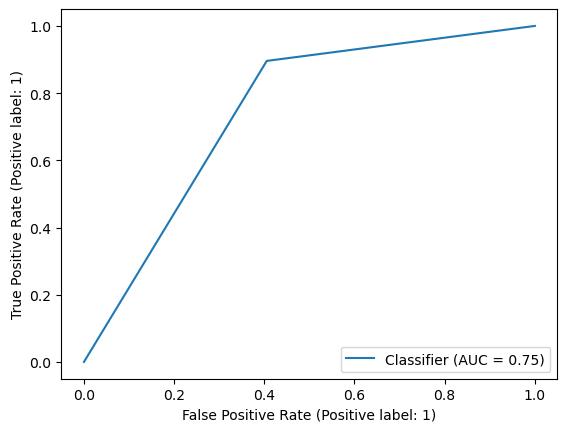

In [298]:
RocCurveDisplay.from_predictions(y_test,best_rf_preds)

### Precision-Recall Curve

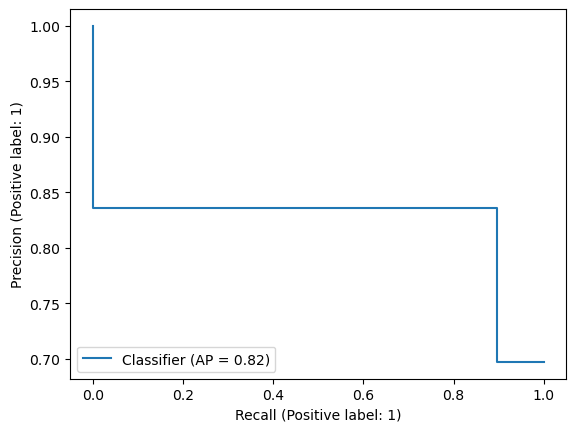

In [299]:
PrecisionRecallDisplay.from_predictions(y_test,best_rf_preds)

## Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression

In [70]:
log_pipe = deepcopy(preprocess_pipeline)
log_pipe.steps.append(('log_reg',LogisticRegression(random_state=418)))
log_pipe

Pipeline(steps=[('tfdif', TfidfVectorizer()),
                ('log_reg', LogisticRegression(random_state=418))])

In [34]:
log_pipe.fit(X_train,y_train)

C:\Users\devin\anaconda3\envs\spotify-project\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfdif', TfidfVectorizer()),
                ('log_reg', LogisticRegression(random_state=418))])

Our model with default params did not converge! In our model-tuning steps, we'll use `RandomziedSearchCV` to optimize for different `max_iters`.

In [35]:
preds3 = log_pipe.predict(X_test)

### Confusion  Matrix Display

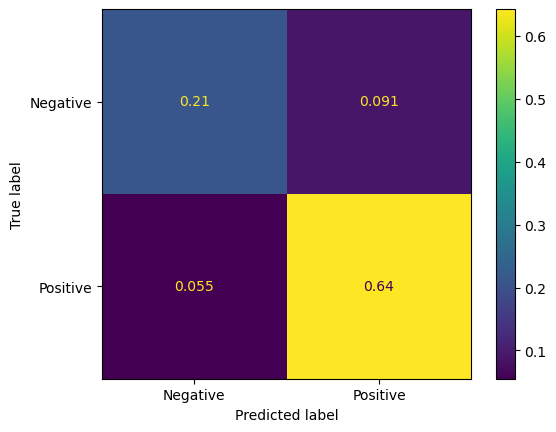

In [366]:
ConfusionMatrixDisplay.from_predictions(y_test, preds3,normalize='all',display_labels=class_labels)

### Classification Report

In [37]:
print(classification_report(y_test,preds3))

              precision    recall  f1-score   support

           0       0.79      0.70      0.74      5229
           1       0.88      0.92      0.90     12043

    accuracy                           0.85     17272
   macro avg       0.83      0.81      0.82     17272
weighted avg       0.85      0.85      0.85     17272



### ROC 

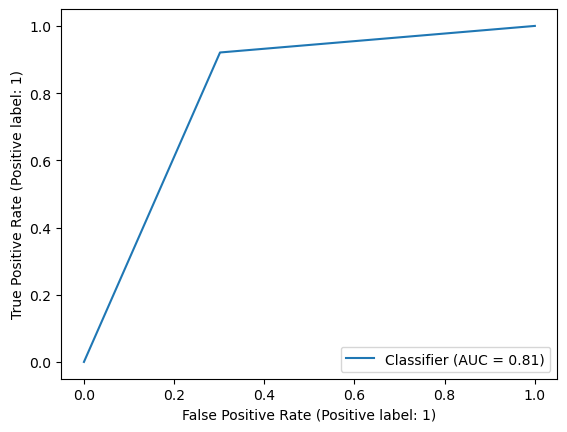

In [38]:
RocCurveDisplay.from_predictions(y_test,preds3)

### Precision-Recall Curve

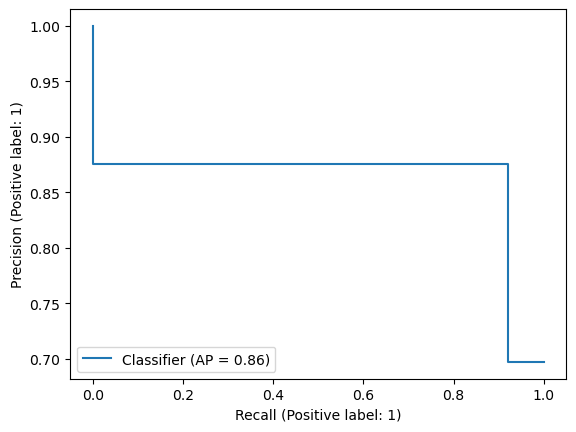

In [39]:
PrecisionRecallDisplay.from_predictions(y_test,preds3)

## Hyperparamter Tuning

In [71]:
log_pipe.steps

[('tfdif', TfidfVectorizer()),
 ('log_reg', LogisticRegression(random_state=418))]

In [77]:
random_cv_params = {'tfdif__min_df':[.01,.03,.05],
                    'tfdif__max_df':[.85,.90,.95],
                    'log_reg__C':[1e-3,1e-2,1e-1,1,1.01,1.1,1e1],
                    'log_reg__max_iter':[100,120,140]}

In [78]:
random_cv = RandomizedSearchCV(estimator=log_pipe,
                               param_distributions=random_cv_params,
                               cv=5)
random_cv.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfdif', TfidfVectorizer()),
                                             ('log_reg',
                                              LogisticRegression(random_state=418))]),
                   param_distributions={'log_reg__C': [0.001, 0.01, 0.1, 1,
                                                       1.01, 1.1, 10.0],
                                        'log_reg__max_iter': [100, 120, 140],
                                        'tfdif__max_df': [0.85, 0.9, 0.95],
                                        'tfdif__min_df': [0.01, 0.03, 0.05]})

In [80]:
best_log_preds = random_cv.best_estimator_.predict(X_test)

### Classification Report

In [84]:
print(classification_report(y_test,best_log_preds))

              precision    recall  f1-score   support

           0       0.71      0.63      0.67      5229
           1       0.85      0.89      0.87     12043

    accuracy                           0.81     17272
   macro avg       0.78      0.76      0.77     17272
weighted avg       0.81      0.81      0.81     17272



### ROC-AUC Curve

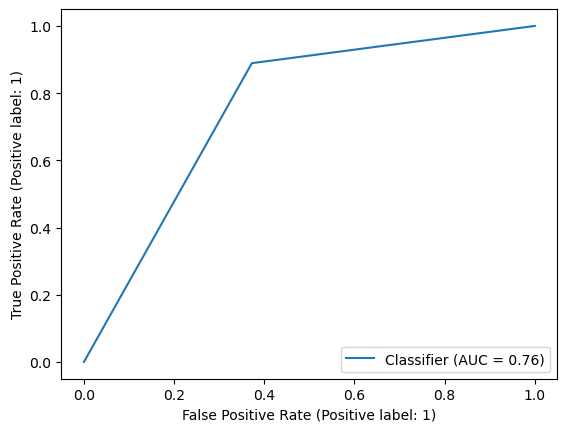

In [83]:
RocCurveDisplay.from_predictions(y_test,best_log_preds)

### Precision-Recall Curve

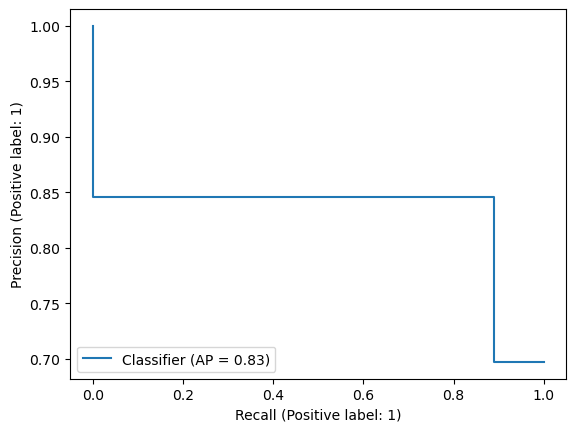

In [81]:
PrecisionRecallDisplay.from_predictions(y_test,best_log_preds)

In [82]:
pd.DataFrame(random_cv.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tfdif__min_df,param_tfdif__max_df,param_log_reg__max_iter,param_log_reg__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,0.477808,0.005425,0.091789,0.003052,0.01,0.9,100,1.1,"{'tfdif__min_df': 0.01, 'tfdif__max_df': 0.9, ...",0.806848,0.807320,0.811042,0.817742,0.817866,0.812164,0.004829,1
0,0.493678,0.018694,0.100155,0.005089,0.01,0.9,100,1,"{'tfdif__min_df': 0.01, 'tfdif__max_df': 0.9, ...",0.807220,0.807196,0.811042,0.817246,0.817866,0.812114,0.004663,2
2,0.554110,0.150408,0.109018,0.008788,0.03,0.85,120,1.1,"{'tfdif__min_df': 0.03, 'tfdif__max_df': 0.85,...",0.769383,0.769851,0.771216,0.777543,0.778784,0.773356,0.003991,3
3,0.478026,0.013424,0.107909,0.005510,0.03,0.85,100,1.1,"{'tfdif__min_df': 0.03, 'tfdif__max_df': 0.85,...",0.769383,0.769851,0.771216,0.777543,0.778784,0.773356,0.003991,3
5,0.434901,0.018740,0.109916,0.019440,0.03,0.85,100,1.01,"{'tfdif__min_df': 0.03, 'tfdif__max_df': 0.85,...",0.769508,0.769603,0.771216,0.777792,0.778660,0.773356,0.004032,5


The results from `RandomizedSearchCV` did not improve model performance. 

### !? Feature Importance (Word Importance)

In [280]:
word_map = [(x,words[x]) for x in words]
word_map.sort(key=lambda x:x[1])

In [281]:
imp_vocab = [x[0] for x in word_map]
len(imp_vocab)

239

In [282]:
imp_word_coef = list(zip(imp_vocab,word_importance))
correct_df = pd.DataFrame(imp_word_coef, columns=['Word', 'Weight'])
correct_df.sort_values('Weight',ascending=False).head(5)

,Word,Weight
238,youtube,7.109326
237,year,6.494775
236,wrong,6.276055
235,worth,4.768352
234,work,4.756832


In [276]:
correct_df.sort_values('Weight',ascending=False).tail(5)

,Word,Weight
0,able,"[-0.05551596122666093, -0.531680428160093, -0...."


In [253]:
positive_dict = {x[0]:x[1] for x in imp_word_coef}

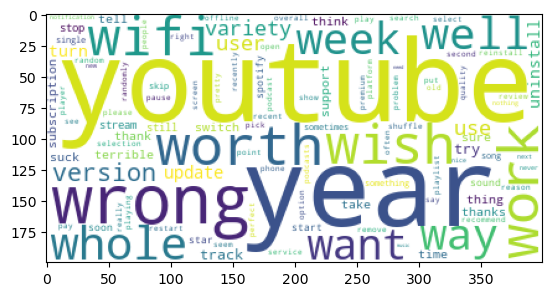

In [257]:
wordcloud.generate_from_frequencies(positive_dict)
plt.imshow(wordcloud)

In [258]:
neg_words = list(zip(imp_vocab,word_importance*-1))
negative_dict = {x[0]:x[1] for x in important_words}

In [271]:
spotify_df[(spotify_df.review.str.contains('youtube')) & (spotify_df.sentiment=='pos')].review.head().values

array(["improve the ia to recommend songs and to find similar songs and it'll be the best music app, youtube is better on that, on everything else, spotify is the king!",
       'so you mean to tell me that on order to listen to the songs that i want to on mobile and not some random song that will play instead, i am required to pay for premium? yeah, no. one star, and going back to youtube.',
       'i have a love/hate relationship with this app. i dont mind the ads, its the fact that i cant choose what songs i want to listen to anymore. i only get previews of the songs. i can only get 6 skips per hour. i cant do anything i want. almosr all the songs i like to listen to are only for premium users. you put so many restrictions on us. id rather pay for tidal. 2022 update: switched to youtube music my life is so much better 😻😻',
       "i've been using youtube music for 3 years but a few days ago i bought spotify premium edition to see which one is better, to be honest spotify has better 

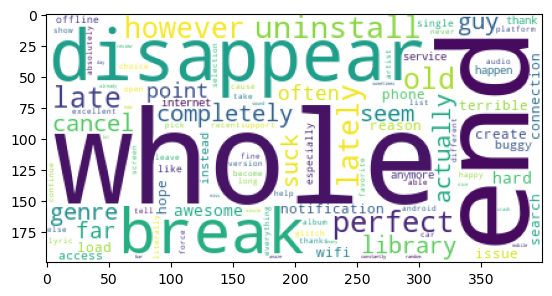

In [260]:
wordcloud.generate_from_frequencies(negative_dict)
plt.imshow(wordcloud)

In [ ]:
#testing something ^

In [279]:
words = random_cv.best_estimator_.steps[0][1].vocabulary_
word_importance = random_cv.best_estimator_.named_steps['log_reg'].coef_
word_importance = np.unique(word_importance)
important_words = list(zip(words,word_importance))

In [149]:
# creating a dataframe with words and their coefs 
imp_words_df = pd.DataFrame(important_words, columns=['Word', 'Weight'])
imp_words_df.sort_values('Weight',ascending=False).head(10)

,Word,Weight
238,whole,7.109326
237,end,6.494775
236,disappear,6.276055
235,break,4.768352
234,uninstall,4.756832
233,perfect,4.505077
232,lately,4.207224
231,late,4.170291
230,old,4.027625
229,however,3.975821


In [154]:
imp_words_df.sort_values(by='Weight',ascending=False).tail()

,Word,Weight
4,see,-3.654224
3,premium,-3.883971
2,buy,-4.202810
1,ad,-4.863029
0,hate,-5.554982


In [146]:
# top ten words with the highest negative correlation to target label 
# these words have an inverse relationship with classifying a review as positive or negative
imp_words_df.sort_values(by='Weight',ascending=False).tail(10)

,Word,Weight
9,good,-1.722023
8,ever,-2.252735
7,thing,-2.477261
6,app,-2.954690
5,sure,-3.488765
4,see,-3.654224
3,premium,-3.883971
2,buy,-4.202810
1,ad,-4.863029
0,hate,-5.554982


In [156]:
coef_dict = {x[0]:x[1] for x in important_words}

In [159]:
from wordcloud import WordCloud

In [162]:
import matplotlib.pyplot as plt 

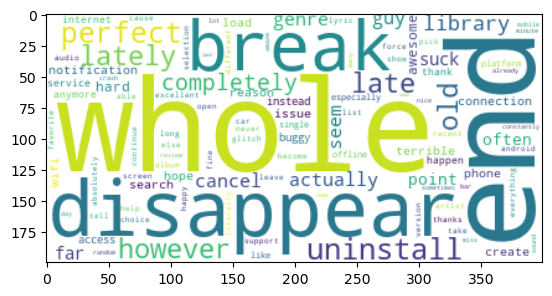

In [163]:
wordcloud = WordCloud(background_color='white')

wordcloud.generate_from_frequencies(coef_dict)
plt.imshow(wordcloud,interpolation='bilinear')

In [165]:
neg_coef_list = list(zip(words,word_importance*-1))
neg_coef_dict = {x[0]:x[1] for x in important_words}

In [219]:
neg_coef_dict

{'hate': -5.554982081105348,
 'ad': -4.863028724262688,
 'buy': -4.202810169197359,
 'premium': -3.883970578662337,
 'see': -3.6542236617827717,
 'sure': -3.4887652565147413,
 'app': -2.9546895421607426,
 'thing': -2.4772614718571857,
 'ever': -2.252734748478559,
 'good': -1.7220232493647558,
 'apps': -1.5902901312380329,
 'think': -1.428471891139951,
 'play': -1.4029603210008887,
 'dont': -1.3745560398032197,
 'download': -1.3282312261375142,
 'spotify': -1.2000761113883511,
 'well': -1.1775147185005417,
 'listen': -1.128402646417748,
 'track': -1.1102101324004554,
 'favourite': -1.1050685837194474,
 'connect': -1.098725565600058,
 'year': -1.0353550978182442,
 'add': -0.9286782746082476,
 'skip': -0.9176488287583757,
 'come': -0.8357239364653821,
 'fix': -0.8312054885753737,
 'great': -0.7833020043614004,
 'enjoy': -0.7613549810617652,
 'also': -0.7289827900327743,
 'free': -0.7287840858101163,
 'month': -0.7179807698534889,
 'cant': -0.7169025061151876,
 'even': -0.7086070758134939,

(-0.5, 399.5, 199.5, -0.5)

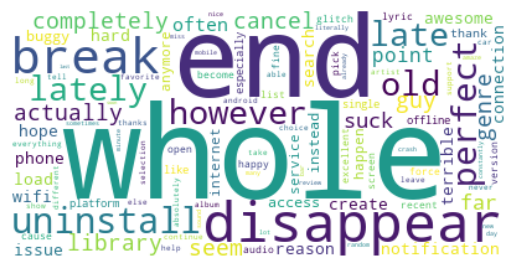

In [218]:
wordcloud = WordCloud(background_color='white')

wordcloud.generate_from_frequencies(neg_coef_dict)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

## Multinomial Naive Bayes

In [47]:
from sklearn.naive_bayes import MultinomialNB

In [48]:
multiNB_pipe = deepcopy(preprocess_pipeline)
multiNB_pipe.steps.append(('multiNB',MultinomialNB()))
multiNB_pipe

Pipeline(steps=[('tfdif', TfidfVectorizer()), ('multiNB', MultinomialNB())])

In [49]:
multiNB_pipe.fit(X_train,y_train)

Pipeline(steps=[('tfdif', TfidfVectorizer()), ('multiNB', MultinomialNB())])

In [50]:
preds4 = multiNB_pipe.predict(X_test)

### Classification Report 

In [51]:
print(classification_report(y_test, preds4))

              precision    recall  f1-score   support

           0       0.78      0.36      0.49      5229
           1       0.77      0.96      0.86     12043

    accuracy                           0.78     17272
   macro avg       0.78      0.66      0.67     17272
weighted avg       0.78      0.78      0.75     17272



### Confusion Matrix Display

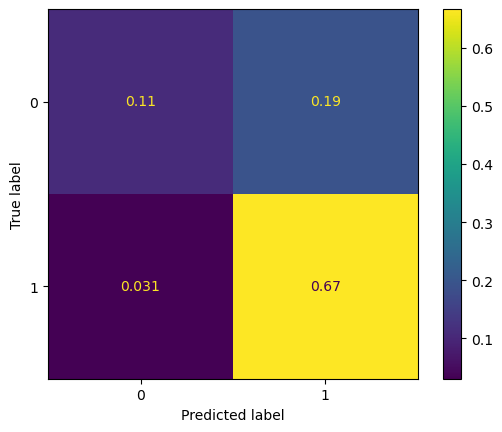

In [52]:
ConfusionMatrixDisplay.from_predictions(y_test, preds4,normalize='all')

### ROC-AUC Curve

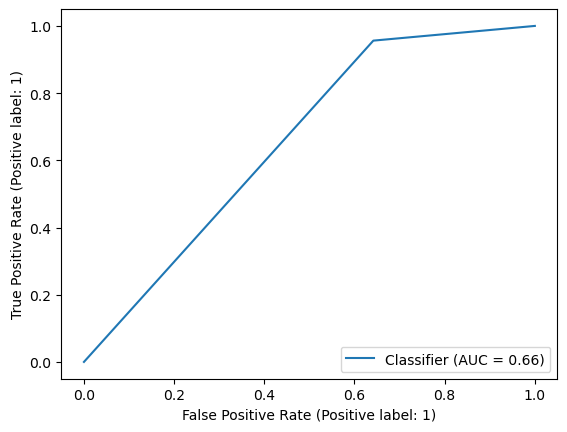

In [301]:
RocCurveDisplay.from_predictions(y_test,preds4)

### Precision-Recall Curve

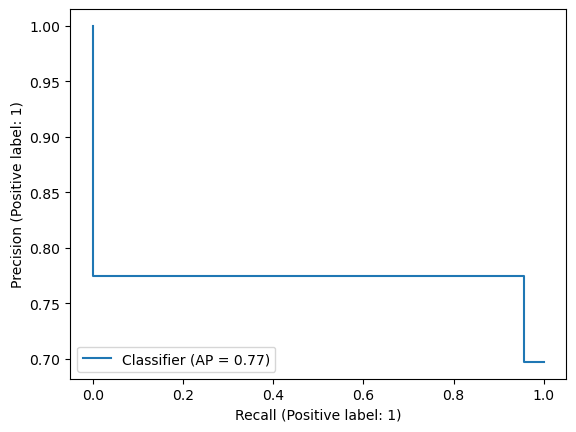

In [53]:
PrecisionRecallDisplay.from_predictions(y_test,preds4)

## Hyperparameter Tuning

In [300]:
multinb_rcv_params = {'tfdif__min_df':[.01,.03,.05],
                    'tfdif__max_df':[.85,.90,.95],
                    'multiNB__alpha':[1e-2, 1e-1, 1, 1e1,1e2]}

In [311]:
multinb_rcv_pipe = RandomizedSearchCV(estimator=multiNB_pipe,
                               param_distributions=multinb_rcv_params,
                               cv=5)

In [312]:
multinb_rcv_pipe.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfdif', TfidfVectorizer()),
                                             ('multiNB', MultinomialNB())]),
                   param_distributions={'multiNB__alpha': [0.01, 0.1, 1, 10.0,
                                                           100.0],
                                        'tfdif__max_df': [0.85, 0.9, 0.95],
                                        'tfdif__min_df': [0.01, 0.03, 0.05]})

In [313]:
best_multinb_preds = multinb_rcv_pipe.predict(X_test)

In [308]:
MultinomialNB().get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}

### Classification Report

In [314]:
print(classification_report(y_test,best_multinb_preds))

              precision    recall  f1-score   support

           0       0.68      0.44      0.53      5229
           1       0.79      0.91      0.85     12043

    accuracy                           0.77     17272
   macro avg       0.74      0.67      0.69     17272
weighted avg       0.76      0.77      0.75     17272



### ROC-AUC Curve

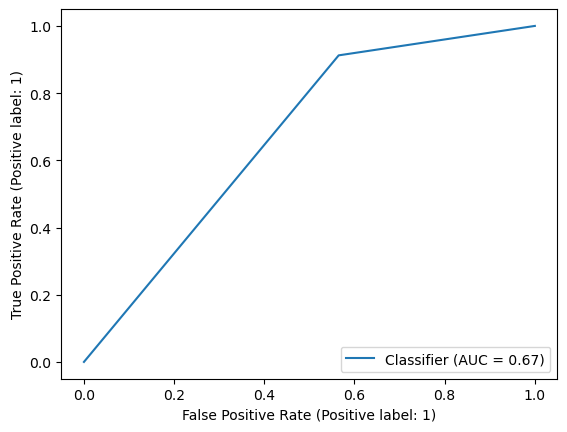

In [315]:
RocCurveDisplay.from_predictions(y_test,best_multinb_preds)

### Precision-Recall Curve

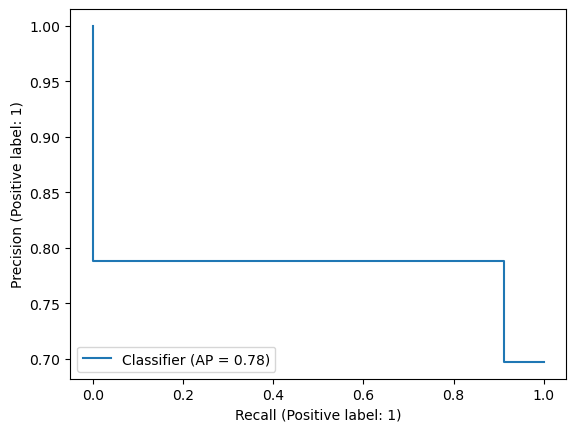

In [316]:
PrecisionRecallDisplay.from_predictions(y_test,best_multinb_preds)

## Complement Naive Bayes

In [54]:
from sklearn.naive_bayes import ComplementNB

In [55]:
compNB_pipe = deepcopy(preprocess_pipeline)
compNB_pipe.steps.append(('compNB',ComplementNB()))
compNB_pipe

Pipeline(steps=[('tfdif', TfidfVectorizer()), ('compNB', ComplementNB())])

In [56]:
compNB_pipe.fit(X_train,y_train)

Pipeline(steps=[('tfdif', TfidfVectorizer()), ('compNB', ComplementNB())])

In [57]:
preds5 = compNB_pipe.predict(X_test)

In [58]:
print(classification_report(y_test, preds5))

              precision    recall  f1-score   support

           0       0.63      0.76      0.69      5229
           1       0.88      0.81      0.84     12043

    accuracy                           0.79     17272
   macro avg       0.76      0.78      0.77     17272
weighted avg       0.81      0.79      0.80     17272



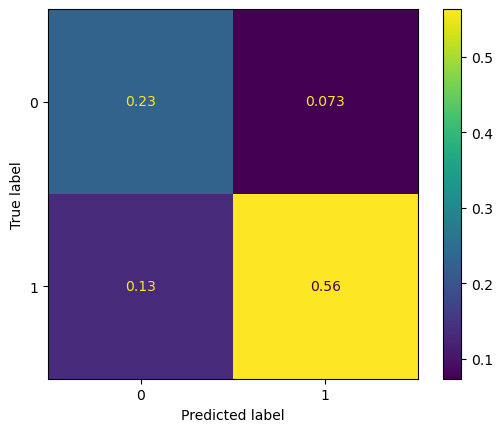

In [59]:
ConfusionMatrixDisplay.from_predictions(y_test, preds5,normalize='all')

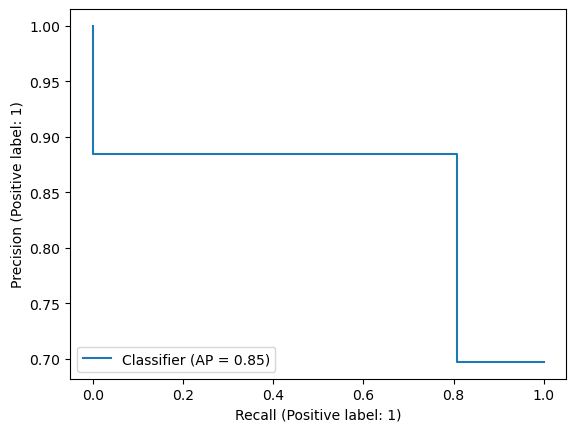

In [60]:
PrecisionRecallDisplay.from_predictions(y_test,preds5)

## Hyperparameter Tuning

In [318]:
compNB_rcv_params = {'tfdif__min_df':[.01,.03,.05],
                    'tfdif__max_df':[.85,.90,.95],
                    'compNB__alpha':[1e-2, 1e-1, 1, 1e1,1e2]}

In [320]:
compNB_rcv_pipe = RandomizedSearchCV(estimator=compNB_pipe,
                               param_distributions=compNB_rcv_params,
                               cv=5)

In [321]:
compNB_rcv_pipe.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfdif', TfidfVectorizer()),
                                             ('compNB', ComplementNB())]),
                   param_distributions={'compNB__alpha': [0.01, 0.1, 1, 10.0,
                                                          100.0],
                                        'tfdif__max_df': [0.85, 0.9, 0.95],
                                        'tfdif__min_df': [0.01, 0.03, 0.05]})

In [322]:
best_compNB_preds = compNB_rcv_pipe.predict(X_test)

### Classification Report

In [323]:
print(classification_report(y_test,best_compNB_preds))

              precision    recall  f1-score   support

           0       0.57      0.78      0.65      5229
           1       0.88      0.74      0.81     12043

    accuracy                           0.75     17272
   macro avg       0.72      0.76      0.73     17272
weighted avg       0.79      0.75      0.76     17272



### ROC-AUC Curve

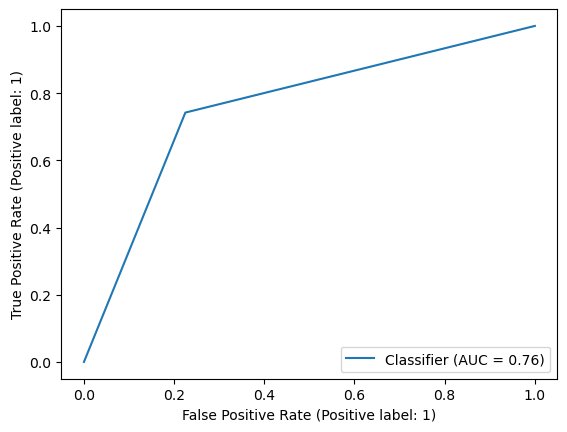

In [324]:
RocCurveDisplay.from_predictions(y_test,best_compNB_preds)

### Precision-Recall Curve

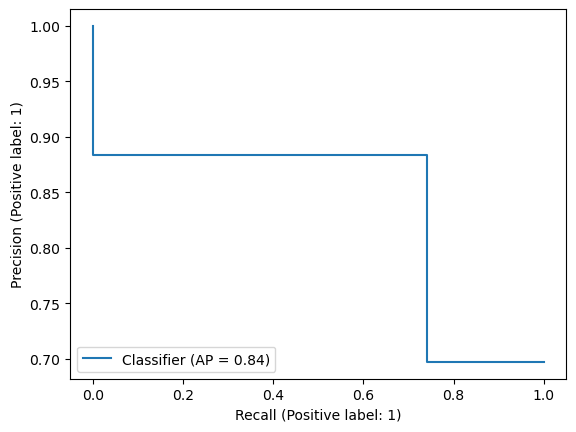

In [325]:
PrecisionRecallDisplay.from_predictions(y_test,best_compNB_preds)

## Bernoulli Naive Bayes

In [326]:
from sklearn.naive_bayes import BernoulliNB

In [327]:
bernoulliNB_pipe = deepcopy(preprocess_pipeline)
bernoulliNB_pipe.steps.append(('bernoulliNB',BernoulliNB()))
bernoulliNB_pipe

Pipeline(steps=[('tfdif', TfidfVectorizer()), ('bernoulliNB', BernoulliNB())])

In [328]:
bernoulliNB_pipe.fit(X_train,y_train)

Pipeline(steps=[('tfdif', TfidfVectorizer()), ('bernoulliNB', BernoulliNB())])

In [329]:
preds7 = bernoulliNB_pipe.predict(X_test)

### Classification Report 

In [330]:
print(classification_report(y_test, preds7))

              precision    recall  f1-score   support

           0       0.61      0.60      0.60      5229
           1       0.83      0.83      0.83     12043

    accuracy                           0.76     17272
   macro avg       0.72      0.72      0.72     17272
weighted avg       0.76      0.76      0.76     17272



### Confusion Matrix Display

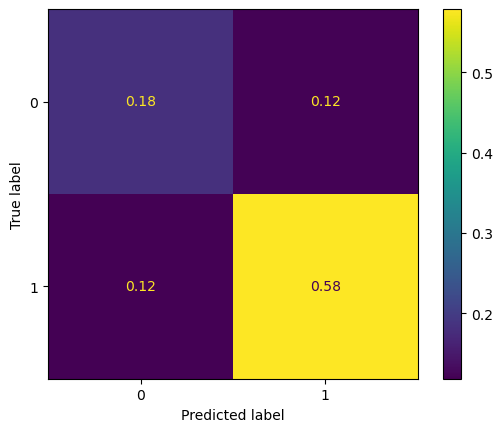

In [331]:
ConfusionMatrixDisplay.from_predictions(y_test, preds7,normalize='all')

### ROC-AUC Curve

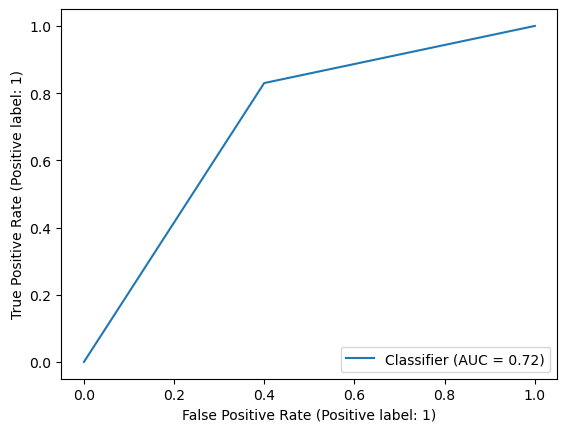

In [332]:
RocCurveDisplay.from_predictions(y_test,preds7)

### Precision-Recall Curve

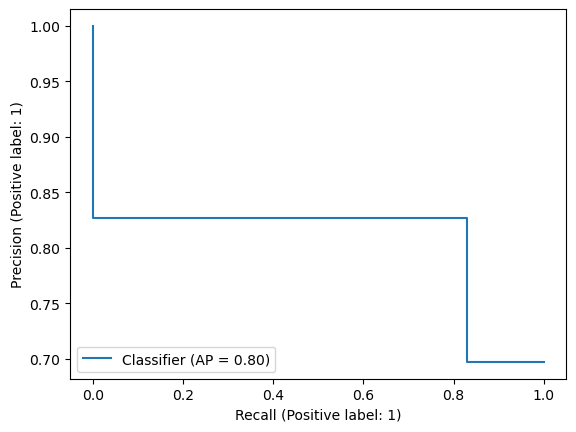

In [333]:
PrecisionRecallDisplay.from_predictions(y_test,preds7)

## XGBoost Model 

In [334]:
from xgboost import XGBClassifier

In [335]:
xgb_pipe = deepcopy(preprocess_pipeline)
xgb_pipe.steps.append(('xgbModel',XGBClassifier(random_state=42)))
xgb_pipe

Pipeline(steps=[('tfdif', TfidfVectorizer()),
                ('xgbModel',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [336]:
xgb_pipe.fit(X_train,y_train)
preds6 = xgb_pipe.predict(X_test)

### Classification Report

In [337]:
print(classification_report(y_test, preds6))

              precision    recall  f1-score   support

           0       0.78      0.64      0.71      5229
           1       0.86      0.92      0.89     12043

    accuracy                           0.84     17272
   macro avg       0.82      0.78      0.80     17272
weighted avg       0.83      0.84      0.83     17272



### Confusion Matrix Display

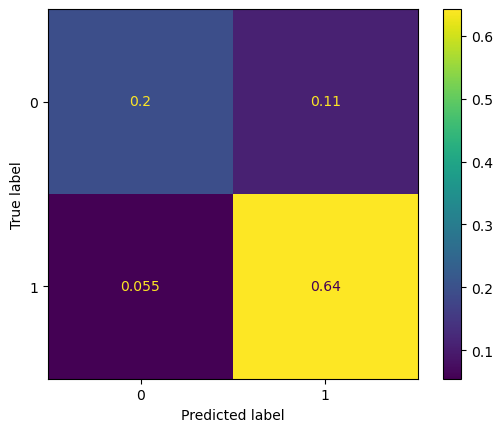

In [338]:
ConfusionMatrixDisplay.from_predictions(y_test, preds6,normalize='all')

### Precision-Recall AUC

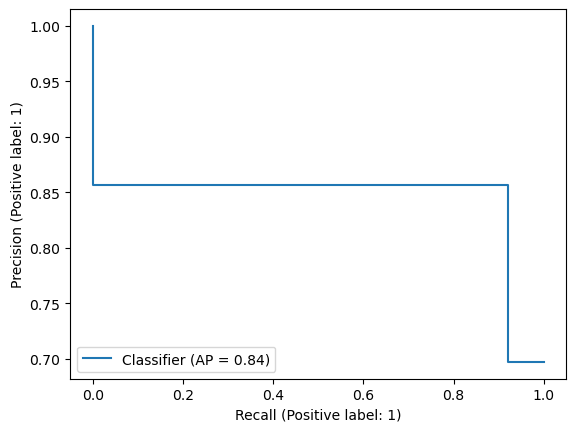

In [339]:
PrecisionRecallDisplay.from_predictions(y_test,preds6)

In [340]:
xgb_params = {'tfdif__min_df':[.01,.03,.05],
              'tfdif__max_df':[.85,.90,.95],
              'xgbModel__max_depth': [3,4, 5], 
              'xgbModel__learning_rate': [.1, .3, .5],
              'xgbModel__gamma': [0,5,10], 
              'xgbModel__n_estimators': [50,100, 150] }

In [341]:
xgb_rcv_pipe = RandomizedSearchCV(estimator=xgb_pipe,
                                  param_distributions=xgb_params,
                                 cv=5)

In [342]:
xgb_rcv_pipe.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfdif', TfidfVectorizer()),
                                             ('xgbModel',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_types=None,
                                                            gamma=None,
                                                            gpu_id=None,
                                                            grow_policy=None,
                                                            importa...
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            n_estimators=100,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            predictor=None,
                                                            random_state=42, ...))]),
                   param_distributions={'tfdif__max_df': [0.85, 0.9, 0.95],
                                        'tfdif__min_df': [0.01, 0.03, 0.05],
                                        'xgbModel__gamma': [0, 5, 10],
                                        'xgbModel__learning_rate': [0.1, 0.3,
                                                                    0.5],
                                        'xgbModel__max_depth': [3, 4, 5],
                                        'xgbModel__n_estimators': [50, 100,
                                                                   150]})

In [343]:
best_xgb_preds = xgb_rcv_pipe.predict(X_test)

### Classification Report

In [346]:
print(classification_report(y_test, best_xgb_preds))

              precision    recall  f1-score   support

           0       0.72      0.59      0.65      5229
           1       0.84      0.90      0.87     12043

    accuracy                           0.81     17272
   macro avg       0.78      0.75      0.76     17272
weighted avg       0.80      0.81      0.80     17272



### Confusion Matrix Display

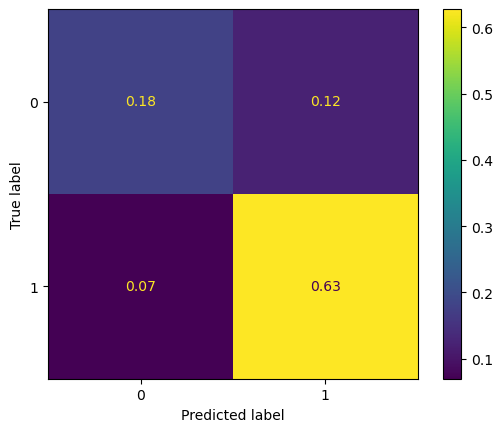

In [345]:
ConfusionMatrixDisplay.from_predictions(y_test, best_xgb_preds,normalize='all')

### ROC-AUC 

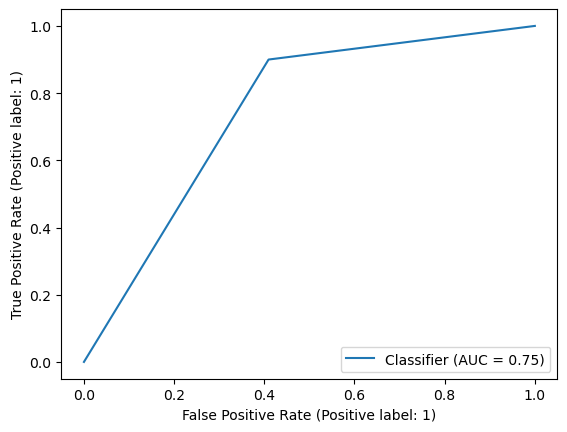

In [347]:
RocCurveDisplay.from_predictions(y_test, best_xgb_preds)

### Precision-Recall AUC

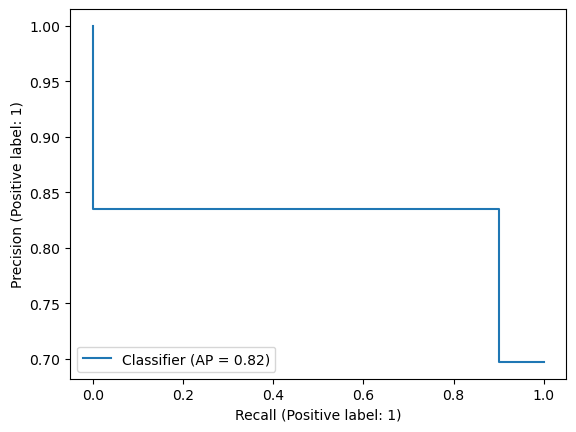

In [344]:
PrecisionRecallDisplay.from_predictions(y_test,best_xgb_preds)

**BEST MODEL**:

Using our evaluation criteria, the best model is a logistic regression without hyperparameter tuning:
- accuracy: .86
- macro_f1_score: .82 